## 《An Image is Worth 16 x 16 Words: transformers for image recognition at scale》

### (1)网络结构设计和实现 Vision Transformer
![](Md_img/2023-06-20-10-51-19.png)

标准的Transformer是对一维序列的 token embedding，所以需要转换。

**图片转换为patch**

为了能够处理二维数据，将一张 $x \in R^{H \times W \times C}$ 图片变为一系列 二维 patch $x_p  \in R^{N \times (P^2.C)}$。其中 $(H,W)$是原始图片的分辨率，$C$是原始图片的通道。 $(P,P)$ 是每一个patch的分辨率， $N = HW/P^2 = H/P * W/P$ 是patch的数量。 

**线性映射为D维隐变量**

由于transformer使用D维大小的常隐变量响铃，可以通过一个线性映射得到从 patch到patch embedding的转变

$$z_0 = [x_{class};x_p^1E;x_p^2E; ... ;x_p^NE;] + E_{pos}$$

**Class token**

注意，这里我们将分类的标签作为一个可以学习的token放在了 序列embedding的头部，我们将使用这个参数作为分类标志。

**位置编码**

位置编码是一个1D的位置编码，本文没有发现2D的位置编码可以明显提高效果


### (2) 参数设置

In [3]:
import argparse
import datetime
import os 

parser = argparse.ArgumentParser(description='Transformer')
parser.add_argument('--epochs', type=int, default=200)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--n_classes', type=int, default=10)
parser.add_argument('--num_workers', type=int, default=4)
parser.add_argument('--lr', type=float, default=5e-4)
parser.add_argument('--log_step', type=int, default=50)

parser.add_argument('--dset', type=str, default='mnist', help=['mnist', 'fmnist'])
parser.add_argument("--img_size", type=int, default=28, help="Img size")
parser.add_argument("--patch_size", type=int, default=4, help="Patch Size")
parser.add_argument("--n_channels", type=int, default=1, help="Number of channels")
parser.add_argument('--data_path', type=str, default='./data')
parser.add_argument('--model_path', type=str, default='./model')

parser.add_argument("--embed_dim", type=int, default=96, help="dimensionality of the latent space")
parser.add_argument("--n_attention_heads", type=int, default=4, help="number of heads to be used")

parser.add_argument("--forward_mul", type=int, default=2, help="forward multiplier")
parser.add_argument("--n_layers", type=int, default=6, help="number of encoder layers")
parser.add_argument("--load_model", type=bool, default=False, help="Load saved model")

start_time = datetime.datetime.now()
print("Started at " + str(start_time.strftime('%Y-%m-%d %H:%M:%S')))

args = parser.parse_args(args=[])
args.model_path = os.path.join(args.model_path, args.dset)
print(args)

Started at 2023-06-22 10:57:27
Namespace(batch_size=128, data_path='./data', dset='mnist', embed_dim=96, epochs=200, forward_mul=2, img_size=28, load_model=False, log_step=50, lr=0.0005, model_path='./model/mnist', n_attention_heads=4, n_channels=1, n_classes=10, n_layers=6, num_workers=4, patch_size=4)


### (3) 模型构建

In [4]:
import torch
import torch.nn as nn

# B -> Batch size
# C -> Number of Input channels

# IH -> Image Height
# IW -> Image Width
# P -> Patch size

# E -> Embedding Dimension
# S -> （the number of patchs）Sequence Length = IH/P * IW/P

# Q -> Query Sequence Length 
# K -> Key Sequence length
# V -> Value Sequence length(same as Key length)

# H -> Number of head
# HE -> Head Embedding Dimension = E/H

In [5]:
class EmbedLayer(nn.Module):
    """
        embedding for images
        (1) image -> patch
        (2) patch -> flatten patch embeddings
        (3) adding classification tokens (parameters for learn)
        (4) adding pos_embedding
    """
    def __init__(self,args):
        super().__init__()
        self.args = args
        self.conv1 = nn.Conv2d(args.n_channels,
                            args.embed_dim,
                            kernel_size=args.patch_size,
                            stride=args.patch_size) # pixcel embedding
        self.cls_token = nn.Parameter(torch.zeros(1,1,args.embed_dim),requires_grad=True) # cls token
        self.pos_embedding = nn.Parameter(torch.zeros(1,(args.img_size//args.patch_size)**2+1,args.embed_dim),requires_grad=True) # position embedding
    
    def forward(self,x):
        x = self.conv1(x) # B C IH IW -> B E IH/P IW/P (embedding the patches)
        x = x.reshape([x.shape[0],self.args.embed_dim,-1]) # B E IH/P IW/P -> B E S(Flattening the patches)
        x = x.transpose(1,2) # B E S -> B S E
        x = torch.cat((torch.repeat_interleave(self.cls_token,x.shape[0],0),x),dim=1) # Adding classification token at the start of every sequence
        x = x + self.pos_embedding # adding positional embedding
        return x 

一些基本的计算公式：
多头注意力机制中的每一个注意力机制的输入分为三个输入 $Q,K,V$，是上一层输出结果的线性变换结果的三种不同形式。

$$Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}}) V$$

多头注意力：

$$MultiHead(Q,K,V) = Concat(head_1,head_2,...,head_h)W^O$$

其中 $head_i = Attention(QW_i^Q,KW_i^K,VW_i^V)$


In [8]:
class SelfAttention(nn.Module):
    """
        Multi-head Attention calculation the same as transformer for sequence data
    """
    def __init__(self,args):
        super().__init__()
        # the number of attention heads
        self.n_attention_heads = args.n_attention_heads
        # the dimension of the embedding
        self.embed_dim = args.embed_dim
        # the embedding dimension of each head 
        self.head_embed_dim = self.embed_dim // self.n_attention_heads
        
        self.queries = nn.Linear(self.embed_dim,self.head_embed_dim*self.n_attention_heads,bias=True)
        self.keys = nn.Linear(self.embed_dim,self.head_embed_dim*self.n_attention_heads,bias=True)
        self.values = nn.Linear(self.embed_dim,self.head_embed_dim*self.n_attention_heads,bias=True)
    
    def forward(self,x):
        """
            Input: Batch, patch number , Embedding
            Output: Batch, query length, number of head
        """
        m,s,e = x.shape # Batch, patch number , Embedding
        # query
        xq = self.queries(x).reshape(m,s,self.n_attention_heads,self.head_embed_dim) # B,Q,E -> B,Q,H,HE
        xq = xq.transpose(1,2) # B,Q,H,HE -> B,H,Q,HE
        # key
        xk = self.keys(x).reshape(m,s,self.n_attention_heads,self.head_embed_dim) # B,K,E -> B,K,H,HE
        xk = xk.transpose(1,2) # B,K,H,HE -> B,H,K,HE
        # value
        xv = self.values(x).reshape(m,s,self.n_attention_heads,self.head_embed_dim) # B,V,E -> B,V,H,HE
        xv = xv.transpose(1,2) # B,V,H,HE -> B,H,V,HE
        
        xq = xq.reshape([-1,s,self.head_embed_dim]) # B,H,Q,HE -> (BH),Q,HE
        xk = xk.reshape([-1,s,self.head_embed_dim]) # B,H,K,HE -> (BH),K,HE
        xv = xv.reshape([-1,s,self.head_embed_dim]) # B,H,V,HE -> (BH),V,HE
        
        # calculate the attention(没有看到除以根号K？)
        xk = xk.transpose(1,2) # (BH),K,HE -> (BH),HE,K
        x_attention = xq.bmm(xk) # (BH),Q,HE * (BH),HE,K -> (BH),Q,K
        x_attention = torch.softmax(x_attention,dim = -1)
        x = x_attention.bmm(xv) # (BH),Q,K * (BH),V,HE -> (BH),Q,HE
        
        x = x.reshape([-1,self.n_attention_heads,s,self.head_embed_dim]) # (BH),Q,HE -> B,H,Q,HE
        x = x.transpose(1,2) # B,H,Q,HE -> B,Q,H,HE
        x = x.reshape(m,s,e) # B,Q,H,HE -> B,Q,E
        return x
        

Encoder说明：
$$LayerNorm(X + MultiHeadAttention(X))$$
$$LayerNorm(X+FeedForward(X))$$

In [9]:
class Encoder(nn.Module):
    """Transformer Encoder"""
    def __init__(self,args):
        super().__init__()
        self.attention = SelfAttention(args)
        self.fc1 = nn.Linear(args.embed_dim,args.embed_dim * args.forward_mul)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(args.embed_dim*args.forward_mul,args.embed_dim)
        self.norm1 = nn.LayerNorm(args.embed_dim)
        self.norm2 = nn.LayerNorm(args.embed_dim)
    
    def forward(self,x):
        # Multihead Attention
        x = x + self.attention(self.norm1(x)) # skip connection
        # Feed Forward model
        x = x + self.fc2(self.activation(self.fc1(self.norm2(x)))) # skip connection
        return x 

In [5]:
class Classifier(nn.Module):
    def __init__(self,args):
        super().__init__()
        self.fc1 = nn.Linear(args.embed_dim,args.embed_dim)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(args.embed_dim,args.n_classes)
    
    def forward(self,x):
        x = x[:,0,:] # get CLS token
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x 

In [6]:
class VisionTransformer(nn.Module):
    def __init__(self,args):
        super().__init__()
        self.embedding = EmbedLayer(args)
        self.encoder = nn.Sequential(*[Encoder(args) for _ in range(args.n_layers)],nn.LayerNorm(args.embed_dim))
        self.norm = nn.LayerNorm(args.embed_dim) # final normalization layer after the last block
        self.classifier = Classifier(args)
    
    def forward(self,x):
        x = self.embedding(x)
        x = self.encoder(x)
        x = self.norm(x)
        x = self.classifier(x)
        return x 

## 数据加载

In [7]:
import torch
from torchvision import datasets
from torchvision import transforms
import os 

def get_loader(args):
    if args.dset == 'mnist':
        tr_transform = transforms.Compose([transforms.RandomCrop(args.img_size,padding=2),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.5],[0.5])
                                            ])
        train = datasets.MNIST(os.path.join(args.data_path,args.dset),train=True,download=True,transform=tr_transform)

        te_transform = transforms.Compose([transforms.Resize([args.img_size,args.img_size]),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.5],[0.5])])
        test = datasets.MNIST(os.path.join(args.data_path,args.dset),train=False,download=True,transform=te_transform)
    elif args.dset=='fmnist':
        tr_transform = transforms.Compose([transforms.RandomCrop(args.img_size,padding=2),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.5],[0.5])
                                            ])
        train = datasets.MNIST(os.path.join(args.data_path,args.dset),train=True,download=True,transform=tr_transform)

        te_transform = transforms.Compose([transforms.Resize(args.img_size,args.img_size),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.5],[0.5])])
        test = datasets.MNIST(os.path.join(args.data_path,args.dest),train=False,download=True,transform=te_transform)
    else:
        print("Unknown datasets")
        exit(0)
    
    train_loader = torch.utils.data.DataLoader(
        dataset = train,
        batch_size = args.batch_size,
        shuffle = True,
        num_workers = args.num_workers,
        drop_last = True
    )
    
    test_loader = torch.utils.data.DataLoader(
        dataset = test,
        batch_size = args.batch_size*2,
        shuffle = False,
        num_workers = args.num_workers,
        drop_last = False
    )
    return train_loader,test_loader

## 求解器

In [8]:
import torch 
import torch.nn as nn
import os
from torch import optim 
from sklearn.metrics import confusion_matrix,accuracy_score


class Solver(object):
    def __init__(self,args):
        self.args = args 
        self.train_loader,self.test_loader = get_loader(args)
        
        self.model = VisionTransformer(args).cuda()
        
        self.ce = nn.CrossEntropyLoss()
        print("----------------------Network----------------------------")
        print(self.model)
        
        if args.load_model:
            print("using pretrained model")
            self.model.load_state_dict(torch.load(os.path.join(self.args.model_path,'Transformer.pt')))
    
    def test_dataset(self,db='test'):
        self.model.eval()
        
        actual = []
        pred = []
        
        if db.lower == 'train':
            loader = self.train_loader
        else:
            loader = self.test_loader
        
        for (imgs,labels) in loader:
            imgs = imgs.cuda()
            
            with torch.no_grad():
                class_out = self.model(imgs)
            
            _,predicted = torch.max(class_out.data,1)
            
            actual += labels.tolist()
            pred += predicted.tolist()
        
        acc = accuracy_score(y_true=actual,y_pred=pred)*100
        cm = confusion_matrix(y_true=actual,y_pred=pred,labels=range(self.args.n_classes))
        return acc,cm
    
    def test(self):
        train_acc, cm = self.test_dataset('train')
        print("Tr Acc: %.2f" % train_acc)
        print(cm)

        test_acc, cm = self.test_dataset('test')
        print("Te Acc: %.2f" % test_acc)
        print(cm)

        return train_acc, test_acc
    
    def train(self):
        iter_per_epoch = len(self.train_loader)
        
        optimizer = optim.AdamW(self.model.parameters(),self.args.lr,weight_decay=1e-3)
        cos_decay = optim.lr_scheduler.CosineAnnealingLR(optimizer,self.args.epochs,verbose=True)
        
        for epoch in range(self.args.epochs):
            self.model.train()
            for i, (imgs, labels) in enumerate(self.train_loader):
                imgs, labels = imgs.cuda(), labels.cuda()
                logits = self.model(imgs)
                clf_loss = self.ce(logits, labels)

                optimizer.zero_grad()
                clf_loss.backward()
                optimizer.step()

                if i % 50 == 0 or i == (iter_per_epoch - 1):
                    print('Ep: %d/%d, it: %d/%d, err: %.4f' % (epoch + 1, self.args.epochs, i + 1, iter_per_epoch, clf_loss))
            test_acc, cm = self.test_dataset('test')
            print("Test acc: %0.2f" % test_acc)
            print(cm, "\n")

            cos_decay.step()

## 训练


In [10]:
# import argparse
# import datetime
# import os 

# def main(args):
#     os.makedirs(args.model_path,exist_ok=True)
#     solver = Solver(args)
#     solver.train()
#     solver.test()

# def print_args(args):
#     for k in dict(sorted(vars(args).items())).items():
#         print(k)
#     print()
    
# if __name__ == '__main__':
#     parser = argparse.ArgumentParser(description='Transformer')
#     parser.add_argument('--epochs', type=int, default=200)
#     parser.add_argument('--batch_size', type=int, default=128)
#     parser.add_argument('--n_classes', type=int, default=10)
#     parser.add_argument('--num_workers', type=int, default=4)
#     parser.add_argument('--lr', type=float, default=5e-4)
#     parser.add_argument('--log_step', type=int, default=50)

#     parser.add_argument('--dset', type=str, default='mnist', help=['mnist', 'fmnist'])
#     parser.add_argument("--img_size", type=int, default=28, help="Img size")
#     parser.add_argument("--patch_size", type=int, default=4, help="Patch Size")
#     parser.add_argument("--n_channels", type=int, default=1, help="Number of channels")
#     parser.add_argument('--data_path', type=str, default='/media/liufeng/a0b205ec-bfb3-473f-a6f0-0680c5da64ba/project/MachineLearning_DeepLearning/data')
#     parser.add_argument('--model_path', type=str, default='./model')

#     parser.add_argument("--embed_dim", type=int, default=96, help="dimensionality of the latent space")
#     parser.add_argument("--n_attention_heads", type=int, default=4, help="number of heads to be used")
    
#     parser.add_argument("--forward_mul", type=int, default=2, help="forward multiplier")
#     parser.add_argument("--n_layers", type=int, default=6, help="number of encoder layers")
#     parser.add_argument("--load_model", type=bool, default=False, help="Load saved model")

#     start_time = datetime.datetime.now()
#     print("Started at " + str(start_time.strftime('%Y-%m-%d %H:%M:%S')))

#     args = parser.parse_args(args=[])
#     args.model_path = os.path.join(args.model_path, args.dset)
#     print(args)
    
#     main(args)

#     end_time = datetime.datetime.now()
#     duration = end_time - start_time
#     print("Ended at " + str(end_time.strftime('%Y-%m-%d %H:%M:%S')))
#     print("Duration: " + str(duration))

In [11]:
os.makedirs(args.model_path,exist_ok=True)
solver = Solver(args)
solver.train()
solver.test()

end_time = datetime.datetime.now()
duration = end_time - start_time
print("Ended at " + str(end_time.strftime('%Y-%m-%d %H:%M:%S')))
print("Duration: " + str(duration))

Started at 2023-06-20 11:46:49
Namespace(batch_size=128, data_path='/media/liufeng/a0b205ec-bfb3-473f-a6f0-0680c5da64ba/project/MachineLearning_DeepLearning/data', dset='mnist', embed_dim=96, epochs=200, forward_mul=2, img_size=28, load_model=False, log_step=50, lr=0.0005, model_path='./model/mnist', n_attention_heads=4, n_channels=1, n_classes=10, n_layers=6, num_workers=4, patch_size=4)
----------------------Network----------------------------
VisionTransformer(
  (embedding): EmbedLayer(
    (conv1): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): Encoder(
      (attention): SelfAttention(
        (queries): Linear(in_features=96, out_features=96, bias=True)
        (keys): Linear(in_features=96, out_features=96, bias=True)
        (values): Linear(in_features=96, out_features=96, bias=True)
      )
      (fc1): Linear(in_features=96, out_features=192, bias=True)
      (activation): GELU(approximate='none')
      (fc2): Linear(in_features=192, 

In [12]:
torch.save(solver.model.state_dict(),"./data/model/mnist/Transformer.pt")

In [28]:
solver.train_loader.dataset.data.shape
solver.test_loader.dataset.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

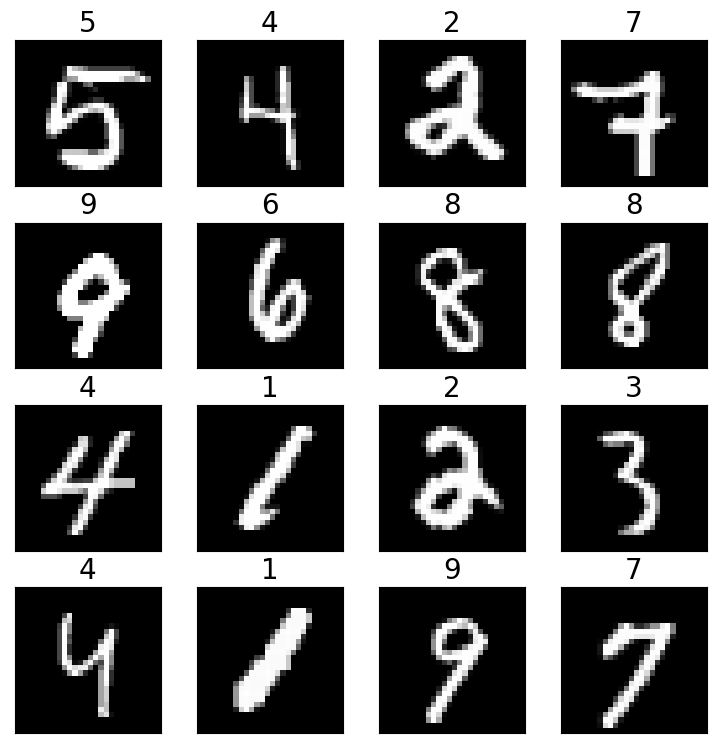

In [42]:
import matplotlib.pyplot as plt
import numpy as np

img,ax = plt.subplots(4,4,figsize=(9,9))
plt.subplots_adjust(hspace=0.25,wspace=0.2)
for i in range(4):
    for j in range(4):
        num = np.random.randint(0,solver.train_loader.dataset.data.shape[0])
        ax[i][j].imshow(solver.train_loader.dataset.data[num],cmap="gray")
        ax[i][j].set_title(solver.train_loader.dataset.targets[num].item(),fontdict={"fontsize":20})
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        
plt.show()

In [44]:
for (imgs,labels) in solver.test_loader:
    imgs = imgs.cuda()
    with torch.no_grad():
        class_out = solver.model(imgs)
    
    _,predicted = torch.max(class_out.data,1)
    break

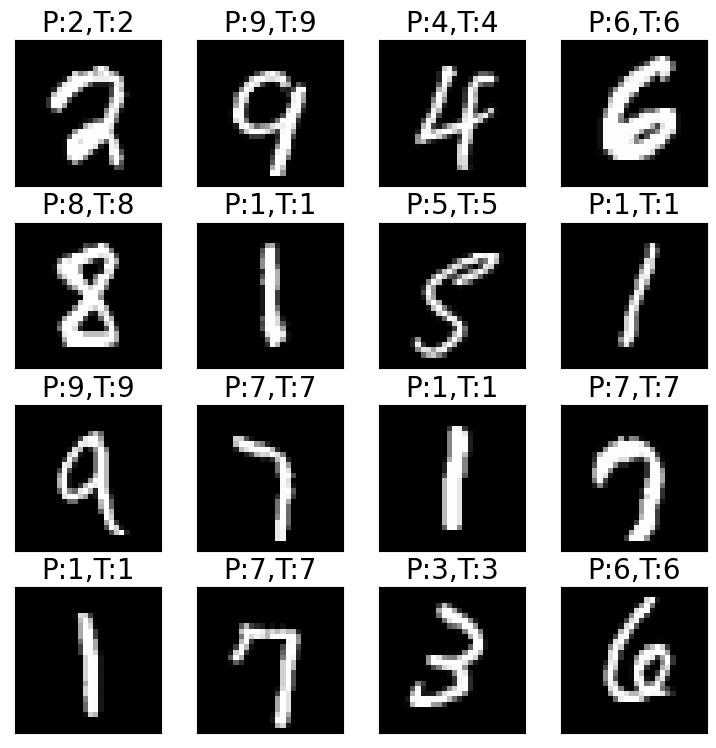

In [54]:
import matplotlib.pyplot as plt
import numpy as np

img,ax = plt.subplots(4,4,figsize=(9,9))
plt.subplots_adjust(hspace=0.25,wspace=0.2)
for i in range(4):
    for j in range(4):
        num = np.random.randint(0,imgs.shape[0])
        ax[i][j].imshow(imgs[num][0].cpu(),cmap="gray")
        ax[i][j].set_title("P:"+str(predicted[num].cpu().item())+",T:"+str(labels[num].item()),fontdict={"fontsize":20})
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        
plt.show()